# Extreme Daily Rainfall Event Classification and Early Warning System

## About the Project

##### This project focuses on identifying and predicting days with "extreme" rainfall (e.g., very heavy or exceptionally heavy rainfall) at a localized level (individual stations or districts), which is crucial for disaster preparedness and issuing early warnings for potential flash floods or waterlogging.

#### Project Goal:

##### To build a classification model that, given historical daily rainfall data for a station and its surroundings, can predict whether the next 24-48 hours will experience an "extreme" rainfall event at that station.

In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


### Libraries 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import BallTree # Crucial import for spatial features
from sklearn.model_selection import train_test_split, TimeSeriesSplit # For splitting data & time-series CV 
from imblearn.over_sampling import SMOTE # For addressing class imbalance


import joblib
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

#### Load the Dataset ---

In [4]:
# --- Load the Dataset ---
try:
    df = pd.read_csv('rainfall_manual_daily_assam_as_1991_2020.csv')
    print("Dataset loaded successfully.")

    print("Initial DataFrame head:")
    print(df.head())

    print("\nInitial DataFrame info:")
    df.info()

except FileNotFoundError:
    print("Error: 'rainfall_manual_daily_assam_as_1991_2020.csv' not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file isn't found


Dataset loaded successfully.
Initial DataFrame head:
   SlNo              Station Agency  State LGD Code  State  District LGD Code  \
0     1  AWRMI Office Campus  Assam              18  Assam                618   
1     2  AWRMI Office Campus  Assam              18  Assam                618   
2     3  AWRMI Office Campus  Assam              18  Assam                618   
3     4  AWRMI Office Campus  Assam              18  Assam                618   
4     5  AWRMI Office Campus  Assam              18  Assam                618   

              District Tehsil Block Village River Basin Tributary  \
0  Kamrup Metropolitan   Rani     -       -     -     -         -   
1  Kamrup Metropolitan   Rani     -       -     -     -         -   
2  Kamrup Metropolitan   Rani     -       -     -     -         -   
3  Kamrup Metropolitan   Rani     -       -     -     -         -   
4  Kamrup Metropolitan   Rani     -       -     -     -         -   

  Subtributary SubSubtributary Local River   

In [4]:
# 1.2 Initial Exploration (for understanding, not requiring code output here)
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())


   SlNo              Station Agency  State LGD Code  State  District LGD Code  \
0     1  AWRMI Office Campus  Assam              18  Assam                618   
1     2  AWRMI Office Campus  Assam              18  Assam                618   
2     3  AWRMI Office Campus  Assam              18  Assam                618   
3     4  AWRMI Office Campus  Assam              18  Assam                618   
4     5  AWRMI Office Campus  Assam              18  Assam                618   

              District Tehsil Block Village River Basin Tributary  \
0  Kamrup Metropolitan   Rani     -       -     -     -         -   
1  Kamrup Metropolitan   Rani     -       -     -     -         -   
2  Kamrup Metropolitan   Rani     -       -     -     -         -   
3  Kamrup Metropolitan   Rani     -       -     -     -         -   
4  Kamrup Metropolitan   Rani     -       -     -     -         -   

  Subtributary SubSubtributary Local River   Latitude  Longitude  \
0            -               -

In [5]:
 # Get unique districts
unique_districts = df['District'].unique().tolist()
unique_districts.sort() # Optional: Sort them alphabetically for better display

print("Complete list of unique districts from your CSV:")
print(unique_districts)


Complete list of unique districts from your CSV:
['BARPETA', 'BONGAIGAON', 'Baksa', 'Chirang', 'DARRANG', 'DHUBRI', 'GOALPARA', 'GOLAGHAT', 'JORHAT', 'KAMRUP', 'KOKRAJHAR', 'Kamrup Metropolitan', 'Majuli', 'NAGAON', 'NALBARI', 'SONITPUR']


## Feature Engineering (Time-based)

In [5]:
# Convert 'Data Acquisition Time' to datetime

df['Data Acquisition Time'] = pd.to_datetime(df['Data Acquisition Time'], format='%d-%m-%Y %H:%M')

# Handle Outliers - Replace the extreme outlier rainfall value with NaN

df.loc[df['Manual Daily Rainfall (mm)'] == 15240.0, 'Manual Daily Rainfall (mm)'] = np.nan

# Handle Missing Data - Fill NaN values in 'Manual Daily Rainfall (mm)' with 0

df['Manual Daily Rainfall (mm)'] = df['Manual Daily Rainfall (mm)'].fillna(0)

# Handle Missing Data - Replace '-' values with NaN in identified columns

columns_to_clean_dash = ['Tehsil', 'Block', 'Village', 'River', 'Basin', 'Tributary', 'Subtributary', 'SubSubtributary', 'Local River']
for col in columns_to_clean_dash:
    df[col] = df[col].replace('-', np.nan).infer_objects(copy=False)

# Extract date-related features

df['Year'] = df['Data Acquisition Time'].dt.year
df['Month'] = df['Data Acquisition Time'].dt.month
df['Day'] = df['Data Acquisition Time'].dt.day
df['DayOfWeek'] = df['Data Acquisition Time'].dt.dayofweek

# Drop columns identified as redundant or entirely NaN during previous exploration

columns_to_drop = [
    'SlNo', 'Agency', 'State LGD Code', 'State', # Redundant/Not useful
    'Block', 'Village', 'Tributary', 'SubSubtributary', # Entirely NaN after '-' replacement
    'River', 'Basin', 'Local River', # Predominantly NaN and not very useful
    'Data Acquisition Time' # Now safe to drop after extracting features
]
df = df.drop(columns=columns_to_drop)

# Define Target Variable - Create 'ExtremeRainfall'
# Calculate the 95th percentile of rainfall

extreme_rainfall_threshold = df['Manual Daily Rainfall (mm)'].quantile(0.95)
df['ExtremeRainfall'] = (df['Manual Daily Rainfall (mm)'] >= extreme_rainfall_threshold).astype(int)

# Display the first few rows of the processed DataFrame to confirm
print(df.head())

# Display info to confirm data types and non-null counts
print(df.info())


               Station  District LGD Code             District Tehsil  \
0  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
1  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
2  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
3  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
4  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   

   Subtributary   Latitude  Longitude  Manual Daily Rainfall (mm)  Year  \
0           NaN  26.102694  91.795097                        10.0  2013   
1           NaN  26.102694  91.795097                        12.0  2013   
2           NaN  26.102694  91.795097                         7.0  2013   
3           NaN  26.102694  91.795097                         1.0  2013   
4           NaN  26.102694  91.795097                         5.0  2013   

   Month  Day  DayOfWeek  ExtremeRainfall  
0      2   18          0                0  
1      3   22         

C:\Users\USER\AppData\Local\Temp\ipykernel_16860\141552423.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', np.nan).infer_objects(copy=False)


### Advanced Feature Engineering and Data Preparation

In [6]:

# --- Load the Dataset ---
try:
    df = pd.read_csv('rainfall_manual_daily_assam_as_1991_2020.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'rainfall_manual_daily_assam_as_1991_2020.csv' not found. Please ensure the file is in the correct directory.")
    exit()

print("\n--- Columns in DataFrame immediately before date parsing logic ---")


print("\n\n--- Starting Step 2: Advanced Feature Engineering and Data Preparation ---")

# Parse the Date Column (Robust Version)

if 'Data Acquisition Time' in df.columns:
    print("\nParsing 'Data Acquisition Time' to datetime format...")
    df['Date'] = df['Data Acquisition Time']
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y %H:%M', errors='coerce')  
    
    before_drop = len(df)
    df = df.dropna(subset=['Date'])
    after_drop = len(df)
    print(f"Dropped {before_drop - after_drop} rows due to unparseable date formats.")

    df.drop(columns=['Data Acquisition Time'], inplace=True)
    print("\n'Data Acquisition Time' column processed, renamed to 'Date', and original dropped.")
elif 'Date' in df.columns:
    print("\n'Date' column already exists. Assuming it's processed.")
else:
    raise ValueError("Error: Neither 'Data Acquisition Time' nor 'Date' column found in the dataset. Cannot proceed with date parsing.")

print("\nMemory usage before sorting (after initial date parsing):")
print(df.memory_usage(deep=True))

df['Station'] = df['Station'].astype(str)

print("Sorting by 'Station' and 'Date'...")
df = df.sort_values(by=['Station', 'Date'])
df.reset_index(drop=True, inplace=True)
print("\nDataFrame after date parsing and sorting (head):")
print(df.head())


Dataset loaded successfully.

--- Columns in DataFrame immediately before date parsing logic ---


--- Starting Step 2: Advanced Feature Engineering and Data Preparation ---

Parsing 'Data Acquisition Time' to datetime format...
Dropped 0 rows due to unparseable date formats.

'Data Acquisition Time' column processed, renamed to 'Date', and original dropped.

Memory usage before sorting (after initial date parsing):
Index                             132
SlNo                           224152
Station                       1805076
Agency                        1513026
State LGD Code                 224152
State                         1513026
District LGD Code              224152
District                      1597151
Tehsil                        1600673
Block                         1400950
Village                       1400950
River                         1404620
Basin                         1404620
Tributary                     1400950
Subtributary                  1400950
SubSubtrib

#### Handle Missing Values

In [7]:
# Handle Missing Values in Manual Daily Rainfall (mm)
df.loc[df['Manual Daily Rainfall (mm)'] == 15240.0, 'Manual Daily Rainfall (mm)'] = np.nan
print(f"\nMissing values in 'Manual Daily Rainfall (mm)' before imputation: {df['Manual Daily Rainfall (mm)'].isnull().sum()}")
df['Manual Daily Rainfall (mm)'] = df.groupby('Station')['Manual Daily Rainfall (mm)'].ffill()
df['Manual Daily Rainfall (mm)'] = df.groupby('Station')['Manual Daily Rainfall (mm)'].bfill()
df['Manual Daily Rainfall (mm)'] = df['Manual Daily Rainfall (mm)'].fillna(0)
print(f"Missing values in 'Manual Daily Rainfall (mm)' after imputation: {df['Manual Daily Rainfall (mm)'].isnull().sum()}")
print("\nDataFrame after rainfall imputation (head):")
print(df.head())


Missing values in 'Manual Daily Rainfall (mm)' before imputation: 1
Missing values in 'Manual Daily Rainfall (mm)' after imputation: 0

DataFrame after rainfall imputation (head):
   SlNo              Station Agency  State LGD Code  State  District LGD Code  \
0     1  AWRMI Office Campus  Assam              18  Assam                618   
1     2  AWRMI Office Campus  Assam              18  Assam                618   
2     3  AWRMI Office Campus  Assam              18  Assam                618   
3     4  AWRMI Office Campus  Assam              18  Assam                618   
4     5  AWRMI Office Campus  Assam              18  Assam                618   

              District Tehsil Block Village River Basin Tributary  \
0  Kamrup Metropolitan   Rani     -       -     -     -         -   
1  Kamrup Metropolitan   Rani     -       -     -     -         -   
2  Kamrup Metropolitan   Rani     -       -     -     -         -   
3  Kamrup Metropolitan   Rani     -       -     -     - 

#### Target Variable

In [8]:
# Define "Extreme Rainfall" Target Variable

df['rainfall_percentile'] = df.groupby('Station')['Manual Daily Rainfall (mm)'].transform(
    lambda x: x.quantile(0.95)
)
df['is_extreme_rainfall'] = (df['Manual Daily Rainfall (mm)'] >= df['rainfall_percentile']).astype(int)
df.drop(columns=['rainfall_percentile'], inplace=True)
print(f"\nDistribution of 'is_extreme_rainfall' (0=Normal, 1=Extreme):")
print(df['is_extreme_rainfall'].value_counts(normalize=True))
print(f"Number of extreme events: {df['is_extreme_rainfall'].sum()}")



Distribution of 'is_extreme_rainfall' (0=Normal, 1=Extreme):
is_extreme_rainfall
0    0.948785
1    0.051215
Name: proportion, dtype: float64
Number of extreme events: 1435


#### Basic Temporal Features

In [9]:
# Create Basic Temporal Features

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
print("\nDataFrame with target variable and temporal features (head):")
print(df.head())


DataFrame with target variable and temporal features (head):
   SlNo              Station Agency  State LGD Code  State  District LGD Code  \
0     1  AWRMI Office Campus  Assam              18  Assam                618   
1     2  AWRMI Office Campus  Assam              18  Assam                618   
2     3  AWRMI Office Campus  Assam              18  Assam                618   
3     4  AWRMI Office Campus  Assam              18  Assam                618   
4     5  AWRMI Office Campus  Assam              18  Assam                618   

              District Tehsil Block Village  ... is_extreme_rainfall  Year  \
0  Kamrup Metropolitan   Rani     -       -  ...                   0  2013   
1  Kamrup Metropolitan   Rani     -       -  ...                   0  2013   
2  Kamrup Metropolitan   Rani     -       -  ...                   0  2013   
3  Kamrup Metropolitan   Rani     -       -  ...                   0  2013   
4  Kamrup Metropolitan   Rani     -       -  ...             

In [10]:
# Create Lagged Rainfall Features
print("\n--- Creating Lagged Rainfall Features ---")
lag_days = [1, 2, 3, 7, 14, 30]
for lag in lag_days:
    df[f'rainfall_lag_{lag}d'] = df.groupby('Station')['Manual Daily Rainfall (mm)'].shift(lag)
    print(f"Created rainfall_lag_{lag}d")
print("\nDataFrame with lagged features (head):")
print(df.head())



--- Creating Lagged Rainfall Features ---
Created rainfall_lag_1d
Created rainfall_lag_2d
Created rainfall_lag_3d
Created rainfall_lag_7d
Created rainfall_lag_14d
Created rainfall_lag_30d

DataFrame with lagged features (head):
   SlNo              Station Agency  State LGD Code  State  District LGD Code  \
0     1  AWRMI Office Campus  Assam              18  Assam                618   
1     2  AWRMI Office Campus  Assam              18  Assam                618   
2     3  AWRMI Office Campus  Assam              18  Assam                618   
3     4  AWRMI Office Campus  Assam              18  Assam                618   
4     5  AWRMI Office Campus  Assam              18  Assam                618   

              District Tehsil Block Village  ... Month_sin     Month_cos  \
0  Kamrup Metropolitan   Rani     -       -  ...  0.866025  5.000000e-01   
1  Kamrup Metropolitan   Rani     -       -  ...  1.000000  6.123234e-17   
2  Kamrup Metropolitan   Rani     -       -  ...  1.0000

#### Rolling Statistics Features

In [11]:
# Create Rolling Statistics Features
print("\n--- Creating Rolling Statistics Features ---")
window_sizes = [3, 7, 14]   # Rolling window for 3 days, 1 week, 2 weeks
for window in window_sizes:
    df[f'rainfall_rolling_mean_{window}d'] = df.groupby('Station')['Manual Daily Rainfall (mm)'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df[f'rainfall_rolling_sum_{window}d'] = df.groupby('Station')['Manual Daily Rainfall (mm)'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )
    print(f"Created rolling mean and sum for {window} days")
print("\nDataFrame with rolling features (head):")
print(df.head())


--- Creating Rolling Statistics Features ---
Created rolling mean and sum for 3 days
Created rolling mean and sum for 7 days
Created rolling mean and sum for 14 days

DataFrame with rolling features (head):
   SlNo              Station Agency  State LGD Code  State  District LGD Code  \
0     1  AWRMI Office Campus  Assam              18  Assam                618   
1     2  AWRMI Office Campus  Assam              18  Assam                618   
2     3  AWRMI Office Campus  Assam              18  Assam                618   
3     4  AWRMI Office Campus  Assam              18  Assam                618   
4     5  AWRMI Office Campus  Assam              18  Assam                618   

              District Tehsil Block Village  ... rainfall_lag_3d  \
0  Kamrup Metropolitan   Rani     -       -  ...             NaN   
1  Kamrup Metropolitan   Rani     -       -  ...             NaN   
2  Kamrup Metropolitan   Rani     -       -  ...             NaN   
3  Kamrup Metropolitan   Rani    

In [12]:
# Integrate Spatial Information from Neighboring Stations

print("\n--- Integrating Spatial Information from Neighboring Stations ---")
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

columns_to_clean_dash_extended = ['Tehsil', 'Block', 'Village', 'River', 'Basin', 'Tributary', 'Subtributary', 'SubSubtributary', 'Local River']
for col in columns_to_clean_dash_extended:
    if col in df.columns:
        df[col] = df[col].replace('-', np.nan).infer_objects(copy=False)
        print(f"Cleaned '-' in '{col}' and inferred object type.")

columns_to_drop_after_initial_load = [
    'SlNo', 'Agency', 'State LGD Code', 'State',
    'Block', 'Village', 'River', 'Basin', 'Tributary', 'Subtributary',
    'SubSubtributary', 'Local River'
]
existing_cols_to_drop = [col for col in columns_to_drop_after_initial_load if col in df.columns]
if existing_cols_to_drop:
    df.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Dropped redundant/empty columns: {existing_cols_to_drop}")

df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
print(f"Dropped rows with missing Latitude/Longitude. Remaining rows: {len(df)}")

stations_coords = df[['Station', 'Latitude', 'Longitude']].drop_duplicates().set_index('Station')
stations_radians = np.deg2rad(stations_coords[['Latitude', 'Longitude']].values)
tree = BallTree(stations_radians, metric='haversine')

neighbor_radius_km = 50
neighbor_radius_radians = neighbor_radius_km / 6371.0

spatial_features_list = []
unique_dates = df['Date'].unique()

for current_date in unique_dates:
    df_on_date = df[df['Date'] == current_date].copy()
    if df_on_date.empty:
        continue
    temp_spatial_data = {}
    for index, row in df_on_date.iterrows():
        station_name = row['Station']
        current_lat_rad = np.deg2rad(row['Latitude'])
        current_lon_rad = np.deg2rad(row['Longitude'])

        ind_rad, dist_rad = tree.query(
            [[current_lat_rad, current_lon_rad]],
            k=len(stations_coords),
            return_distance=True,
            dualtree=True
        )
        distances_km = dist_rad[0] * 6371.0
        neighbor_indices = ind_rad[0][distances_km <= neighbor_radius_km]
        neighbor_stations = stations_coords.iloc[neighbor_indices].index.tolist()
        if station_name in neighbor_stations:
            neighbor_stations.remove(station_name)

        neighbor_lag1_rainfall = df[(df['Station'].isin(neighbor_stations)) &
                                    (df['Date'] == current_date)]['rainfall_lag_1d'].mean()

        if pd.isna(neighbor_lag1_rainfall):
            neighbor_lag1_rainfall = 0

        temp_spatial_data[index] = {
            'Date': current_date,
            'Station': station_name,
            f'neighbor_avg_rainfall_lag_1d_{neighbor_radius_km}km': neighbor_lag1_rainfall
        }
    spatial_features_list.extend(list(temp_spatial_data.values()))

spatial_features_df = pd.DataFrame(spatial_features_list)
df = pd.merge(df, spatial_features_df, on=['Date', 'Station'], how='left')
print("\nDataFrame with all new features (lagged, rolling, spatial):")
print(df.head())
print(df.info())



--- Integrating Spatial Information from Neighboring Stations ---
Cleaned '-' in 'Tehsil' and inferred object type.
Cleaned '-' in 'Block' and inferred object type.
Cleaned '-' in 'Village' and inferred object type.
Cleaned '-' in 'River' and inferred object type.
Cleaned '-' in 'Basin' and inferred object type.
Cleaned '-' in 'Tributary' and inferred object type.
Cleaned '-' in 'Subtributary' and inferred object type.
Cleaned '-' in 'SubSubtributary' and inferred object type.
Cleaned '-' in 'Local River' and inferred object type.
Dropped redundant/empty columns: ['SlNo', 'Agency', 'State LGD Code', 'State', 'Block', 'Village', 'River', 'Basin', 'Tributary', 'Subtributary', 'SubSubtributary', 'Local River']
Dropped rows with missing Latitude/Longitude. Remaining rows: 28019


C:\Users\USER\AppData\Local\Temp\ipykernel_16860\3468475245.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('-', np.nan).infer_objects(copy=False)



DataFrame with all new features (lagged, rolling, spatial):
               Station  District LGD Code             District Tehsil  \
0  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
1  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
2  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
3  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   
4  AWRMI Office Campus                618  Kamrup Metropolitan   Rani   

    Latitude  Longitude  Manual Daily Rainfall (mm)                Date  \
0  26.102694  91.795097                        10.0 2013-02-18 08:30:00   
1  26.102694  91.795097                        12.0 2013-03-22 08:30:00   
2  26.102694  91.795097                         7.0 2013-03-31 08:30:00   
3  26.102694  91.795097                         1.0 2013-04-11 08:30:00   
4  26.102694  91.795097                         5.0 2013-04-15 08:30:00   

   is_extreme_rainfall  Year  ...  rainfall_lag_7

#### Categorical Feature Encoding

In [13]:
# Categorical Feature Encoding
print("\n--- Categorical Feature Encoding ---")
categorical_features = ['Station', 'District', 'Tehsil']
for col in categorical_features:
    df[col] = df[col].astype(str).replace('nan', np.nan).infer_objects(copy=False)
    df.dropna(subset=[col], inplace=True)
    print(f"Column '{col}': {df[col].nunique()} unique values")

if 'Date' in df.columns:
    df.drop(columns=['Date'], inplace=True) # Drop original Date column as it's no longer needed after feature extraction
    print("Dropped 'Date' column.")

df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print("\nDataFrame after One-Hot Encoding (head):")
print(df.head())
print("\nDataFrame columns after One-Hot Encoding:")
print(df.columns.tolist())
print("\n--- Step 2: Advanced Feature Engineering and Data Preparation Complete ---")




--- Categorical Feature Encoding ---
Column 'Station': 43 unique values
Column 'District': 16 unique values
Column 'Tehsil': 29 unique values
Dropped 'Date' column.

DataFrame after One-Hot Encoding (head):
   District LGD Code   Latitude  Longitude  Manual Daily Rainfall (mm)  \
0                618  26.102694  91.795097                        10.0   
1                618  26.102694  91.795097                        12.0   
2                618  26.102694  91.795097                         7.0   
3                618  26.102694  91.795097                         1.0   
4                618  26.102694  91.795097                         5.0   

   is_extreme_rainfall  Year  Month  Day  DayOfWeek  DayOfYear  ...  \
0                    0  2013      2   18          0         49  ...   
1                    0  2013      3   22          4         81  ...   
2                    0  2013      3   31          6         90  ...   
3                    0  2013      4   11          3        101 

### EDA

In [14]:
# 1. Summary Statistics for Numerical Columns
print("\n1. Summary Statistics for Numerical Columns:")
print(df.describe())


1. Summary Statistics for Numerical Columns:
       District LGD Code      Latitude     Longitude  \
count       28019.000000  28019.000000  28019.000000   
mean          362.620151     26.478424     91.638663   
std           139.333320      0.264915      1.344705   
min           280.000000     25.850206     89.830683   
25%           281.000000     26.269722     90.597778   
50%           290.000000     26.498333     91.095803   
75%           301.000000     26.703056     92.924722   
max           706.000000     26.886389     94.262500   

       Manual Daily Rainfall (mm)  is_extreme_rainfall          Year  \
count                28019.000000         28019.000000  28019.000000   
mean                    30.925835             0.051215   2016.304936   
std                     41.441954             0.220440      3.461116   
min                      0.020000             0.000000   2001.000000   
25%                      6.000000             0.000000   2015.000000   
50%              

In [15]:
# 2. Check for Missing Values (after all preprocessing)
print("\n2. Missing Values after all preprocessing:")
print(df.isnull().sum()[df.isnull().sum() > 0])


2. Missing Values after all preprocessing:
rainfall_lag_1d       43
rainfall_lag_2d       86
rainfall_lag_3d      129
rainfall_lag_7d      301
rainfall_lag_14d     602
rainfall_lag_30d    1289
dtype: int64



 Distribution of 'Manual Daily Rainfall (mm)':


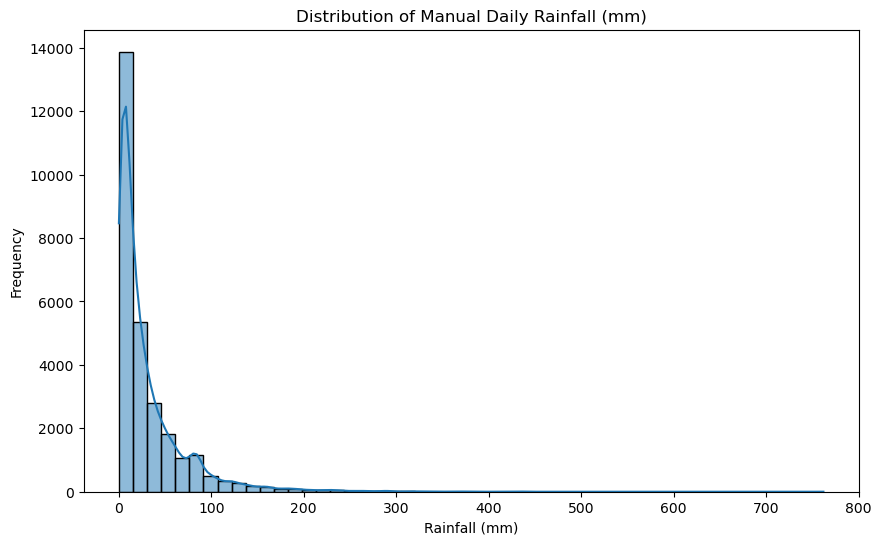

In [16]:
# 3. Distribution of Manual Daily Rainfall (mm)
print("\n Distribution of 'Manual Daily Rainfall (mm)':")
plt.figure(figsize=(10, 6))
sns.histplot(df['Manual Daily Rainfall (mm)'], bins=50, kde=True)
plt.title('Distribution of Manual Daily Rainfall (mm)')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()


 Distribution of Target Variable 'is_extreme_rainfall':
is_extreme_rainfall
0    0.948785
1    0.051215
Name: proportion, dtype: float64


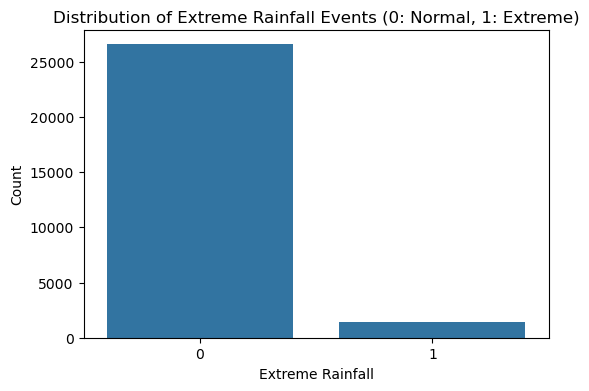

In [17]:
# 4. Distribution of Target Variable 'is_extreme_rainfall'
print("\n Distribution of Target Variable 'is_extreme_rainfall':")
print(df['is_extreme_rainfall'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x='is_extreme_rainfall', data=df)
plt.title('Distribution of Extreme Rainfall Events (0: Normal, 1: Extreme)')
plt.xlabel('Extreme Rainfall')
plt.ylabel('Count')
plt.show()

## Model Selection and Training

In [18]:
# --- Define X and Y for Model Training (Essential for cross-validation) ---
print("\n\n--- Preparing X and Y for Cross-Validation ---")
X = df.drop(columns=['is_extreme_rainfall'])
y = df['is_extreme_rainfall']
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target distribution: \n{y.value_counts(normalize=True)}")



--- Preparing X and Y for Cross-Validation ---
Features (X) shape: (28019, 111)
Target (y) shape: (28019,)
Target distribution: 
is_extreme_rainfall
0    0.948785
1    0.051215
Name: proportion, dtype: float64


In [19]:
# --- Start of Cross-Validation (Time-Series Splits) ---
print("\n\n--- Starting Cross-Validation with Time-Series Splits ---")

# Initialize TimeSeriesSplit
# n_splits: Number of splits. train_size + test_size <= n_samples in each split.
# Each split's training set will be a growing window of historical data.
# The validation set will be the subsequent data points.
# For example, if n_splits=5, the data will be split into roughly 5 sections.
# Fold 1: train on 1, validate on 2
# Fold 2: train on 1+2, validate on 3
# ...
# Fold 5: train on 1+2+3+4, validate on 5
# Adjust n_splits based on dataset size and desired validation periods.
n_splits_cv = 5 # You can change this number
tscv = TimeSeriesSplit(n_splits=n_splits_cv)

# Lists to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Iterate through each fold
for fold, (train_index, val_index) in enumerate(tscv.split(X, y)):
    print(f"\n--- Processing Fold {fold + 1}/{n_splits_cv} ---")

    # Split data for the current fold
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    print(f"Fold {fold+1} - Training data shape: {X_train_fold.shape}, Validation data shape: {X_val_fold.shape}")

    # Handle NaNs introduced by lagged/rolling/spatial features within each fold
    # This is crucial as these NaNs will appear at the start of each train/validation split
    print("Filling NaNs in current fold's training and validation sets with 0...")
    X_train_fold = X_train_fold.fillna(0)
    X_val_fold = X_val_fold.fillna(0)

    # Check NaN counts after imputation for the current fold
    # print(f"NaNs in X_train_fold after imputation: {X_train_fold.isnull().sum().sum()}")
    # print(f"NaNs in X_val_fold after imputation: {X_val_fold.isnull().sum().sum()}")


    # Apply SMOTE to the training data of the current fold (Step 3: Addressing Class Imbalance)
    print("Applying SMOTE to the training data for this fold...")
    smote = SMOTE(random_state=42)
    X_train_fold_res, y_train_fold_res = smote.fit_resample(X_train_fold, y_train_fold)

    print(f"Resampled training data shape for Fold {fold+1}: {X_train_fold_res.shape}")
    print(f"Resampled target distribution for Fold {fold+1}:\n{y_train_fold_res.value_counts(normalize=True)}")

    # Initialize and train the LightGBM Classifier (Step 4: Model Selection and Training)
    print("Training LightGBM Classifier for this fold...")
    lgbm = LGBMClassifier(objective='binary', metric='auc', random_state=42, n_estimators=500, n_jobs=-1) # Use all available cores
    lgbm.fit(X_train_fold_res, y_train_fold_res)
    print("Model training complete for this fold.")

    # Make predictions on the validation set for the current fold
    y_pred_fold = lgbm.predict(X_val_fold)
    y_pred_proba_fold = lgbm.predict_proba(X_val_fold)[:, 1]

    # Evaluate the model for the current fold
    current_accuracy = accuracy_score(y_val_fold, y_pred_fold)
    current_precision = precision_score(y_val_fold, y_pred_fold, zero_division=0)
    current_recall = recall_score(y_val_fold, y_pred_fold, zero_division=0)
    current_f1 = f1_score(y_val_fold, y_pred_fold, zero_division=0)
    current_roc_auc = roc_auc_score(y_val_fold, y_pred_proba_fold)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)
    roc_auc_scores.append(current_roc_auc)

    print(f"Fold {fold+1} Metrics:")
    print(f"  Accuracy: {current_accuracy:.4f}")
    print(f"  Precision: {current_precision:.4f}")
    print(f"  Recall: {current_recall:.4f}")
    print(f"  F1-Score: {current_f1:.4f}")
    print(f"  ROC AUC Score: {current_roc_auc:.4f}")
    # print("\n  Confusion Matrix:\n", confusion_matrix(y_val_fold, y_pred_fold))
    # print("\n  Classification Report:\n", classification_report(y_val_fold, y_pred_fold, zero_division=0))


# Aggregate and print average metrics across all folds
print("\n\n--- Cross-Validation Results (Average across all folds) ---")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"Average ROC AUC Score: {np.mean(roc_auc_scores):.4f} +/- {np.std(roc_auc_scores):.4f}")

print("\n--- Cross-Validation Complete ---")



--- Starting Cross-Validation with Time-Series Splits ---

--- Processing Fold 1/5 ---
Fold 1 - Training data shape: (4674, 111), Validation data shape: (4669, 111)
Filling NaNs in current fold's training and validation sets with 0...
Applying SMOTE to the training data for this fold...
Resampled training data shape for Fold 1: (8882, 111)
Resampled target distribution for Fold 1:
is_extreme_rainfall
0    0.5
1    0.5
Name: proportion, dtype: float64
Training LightGBM Classifier for this fold...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4441, number of negative: 4441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5493
[LightGBM] [Info] Number of data points in the train set: 8882, number of used features:

In [20]:
# --- Prepare X for Final Model Training (Handle any lingering NaNs if not already done globally) ---

print("\n\n--- Preparing X for Final Model Training ---")

# Check for NaNs in the full X dataset before final training
print("Checking for NaNs in the complete X dataset before final imputation:")
nan_cols = X.isnull().sum()[X.isnull().sum() > 0]
if not nan_cols.empty:
    print(nan_cols)
    print("Filling remaining NaNs in the complete X dataset with 0...")
    X = X.fillna(0) # Fill any remaining NaNs with 0 for the final training
    print("NaNs in X after final imputation:")
    print(X.isnull().sum()[X.isnull().sum() > 0]) # Should be empty
else:
    print("No NaNs found in the complete X dataset.")





--- Preparing X for Final Model Training ---
Checking for NaNs in the complete X dataset before final imputation:
rainfall_lag_1d       43
rainfall_lag_2d       86
rainfall_lag_3d      129
rainfall_lag_7d      301
rainfall_lag_14d     602
rainfall_lag_30d    1289
dtype: int64
Filling remaining NaNs in the complete X dataset with 0...
NaNs in X after final imputation:
Series([], dtype: int64)


#### Final Model Training

In [21]:
# --- Final Model Training (Often considered a continuation after CV) ---
print("\n\n--- Step 5: Final Model Training ---")



# Initialize the LightGBM Classifier
# Use the same parameters that performed well during cross-validation
print("Initializing and training the Final LightGBM Classifier on the entire dataset...")
final_lgbm_model = LGBMClassifier(objective='binary', metric='auc', random_state=42, n_estimators=500, n_jobs=-1)

# Train the model on the entire preprocessed X and y dataset
# This model will be used for future predictions
final_lgbm_model.fit(X, y)

print("Final LightGBM Model training complete on the entire dataset.")

# --- Saving the Final Model ---
print("\n\n--- Saving the Final Model ---")

model_filename = 'final_extreme_rainfall_lgbm_model.joblib'
joblib.dump(final_lgbm_model, model_filename)

print(f"Final model saved to: {model_filename}")

print("\n--- Final Model Training and Saving Complete ---")




--- Step 5: Final Model Training ---
Initializing and training the Final LightGBM Classifier on the entire dataset...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1435, number of negative: 26584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4518
[LightGBM] [Info] Number of data points in the train set: 28019, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051215 -> initscore=-2.919145
[LightGBM] [Info] Start training from score -2.919145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light